In [25]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import random

import seaborn as sns


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint


from collections import Counter

## Load data

In [5]:
path = '~/Desktop/CareerFoundry/3.1./'
y = pd.read_pickle(os.path.join(path, 'Data/Clean/y_random_forest.pkl'))
X = pd.read_pickle(os.path.join(path, 'Data/Clean/X_random_forest.pkl'))

## Baseline Random Forest 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [8]:
rf_baseline = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

rf_baseline.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
y_pred = rf_baseline.predict(X_test)

baseline_accuracy = accuracy_score(y_test, y_pred)
baseline_accuracy


0.939419795221843

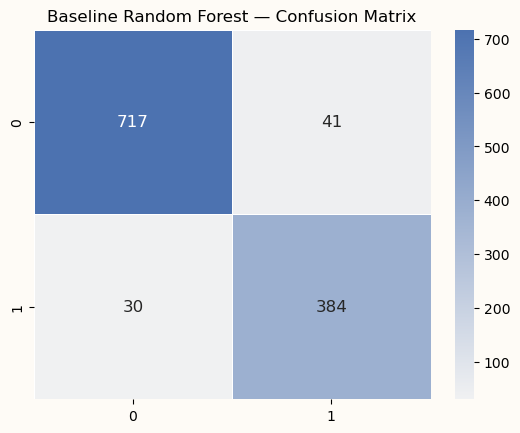

In [16]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap=sns.light_palette("#4C72B0", as_cmap=True),
    cbar=True,
    linewidths=0.5,
    linecolor="white",
    annot_kws={"size": 12}
)


plt.gca().set_facecolor("#FEFBF6")
plt.gcf().patch.set_facecolor('#FEFBF6')

plt.title("Baseline Random Forest â€” Confusion Matrix")
plt.show()


In [17]:
importances = rf_baseline.feature_importances_

feature_importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feature_importance_df.head(10)


,feature,importance
44,DUSSELDORF_temp_max,0.069853
78,MAASTRICHT_temp_mean,0.062889
8,BASEL_temp_max,0.061242
98,MUNCHENB_temp_max,0.060119
80,MAASTRICHT_temp_max,0.054523
51,HEATHROW_temp_mean,0.040284
96,MUNCHENB_temp_mean,0.038416
35,DEBILT_temp_max,0.031766
42,DUSSELDORF_temp_mean,0.031268
6,BASEL_temp_mean,0.027517


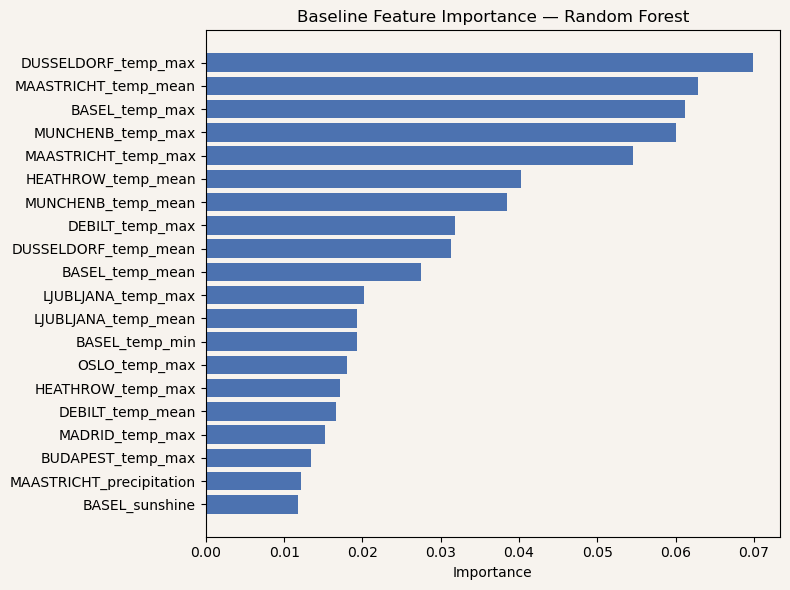

In [22]:
top_n = 20

plt.figure(figsize=(8, 6),  facecolor="#F7F3EE")
         
plt.barh(
    feature_importance_df.head(top_n)["feature"][::-1],
    feature_importance_df.head(top_n)["importance"][::-1],
    color="#4C72B0"
)
plt.gca().set_facecolor("#F7F3EE") 
plt.title("Baseline Feature Importance â€” Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [40]:
# baseline station importance
# extract station names from feature names
baseline_station_importance = (
    feature_importance_df
    .assign(station=lambda df: df["feature"].str.split("_").str[0])
    .groupby("station")["importance"]
    .sum()
    .sort_values(ascending=False)
)

baseline_station_importance

station
MAASTRICHT    0.152701
BASEL         0.141634
DUSSELDORF    0.138348
MUNCHENB      0.132040
DEBILT        0.078967
HEATHROW      0.078924
LJUBLJANA     0.073033
OSLO          0.040833
BELGRADE      0.032640
STOCKHOLM     0.030595
SONNBLICK     0.029843
MADRID        0.028814
BUDAPEST      0.028120
KASSEL        0.010874
VALENTIA      0.002634
Name: importance, dtype: float64

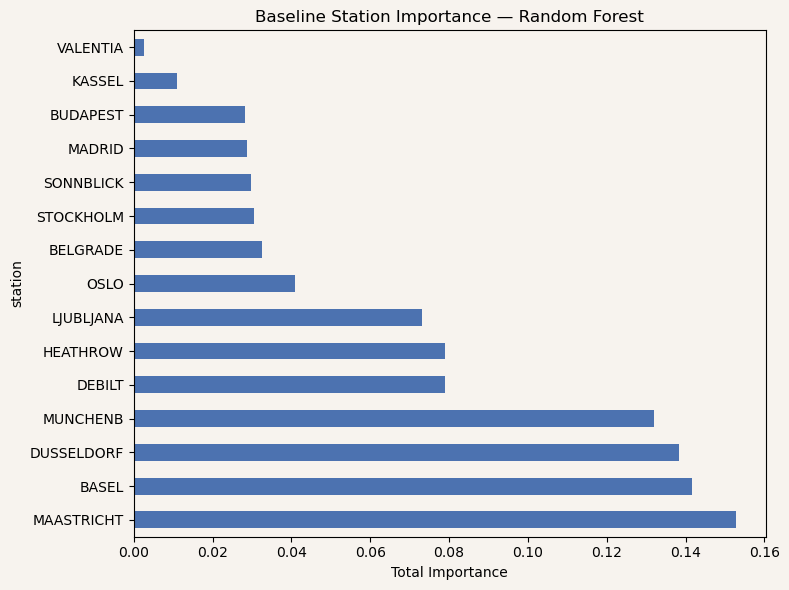

In [41]:
plt.figure(figsize=(8, 6), facecolor="#F7F3EE")

baseline_station_importance.plot(
    kind="barh",
    color="#4C72B0"
)

plt.gca().set_facecolor("#F7F3EE")
plt.title("Baseline Station Importance â€” Random Forest")
plt.xlabel("Total Importance")
plt.tight_layout()
plt.show()


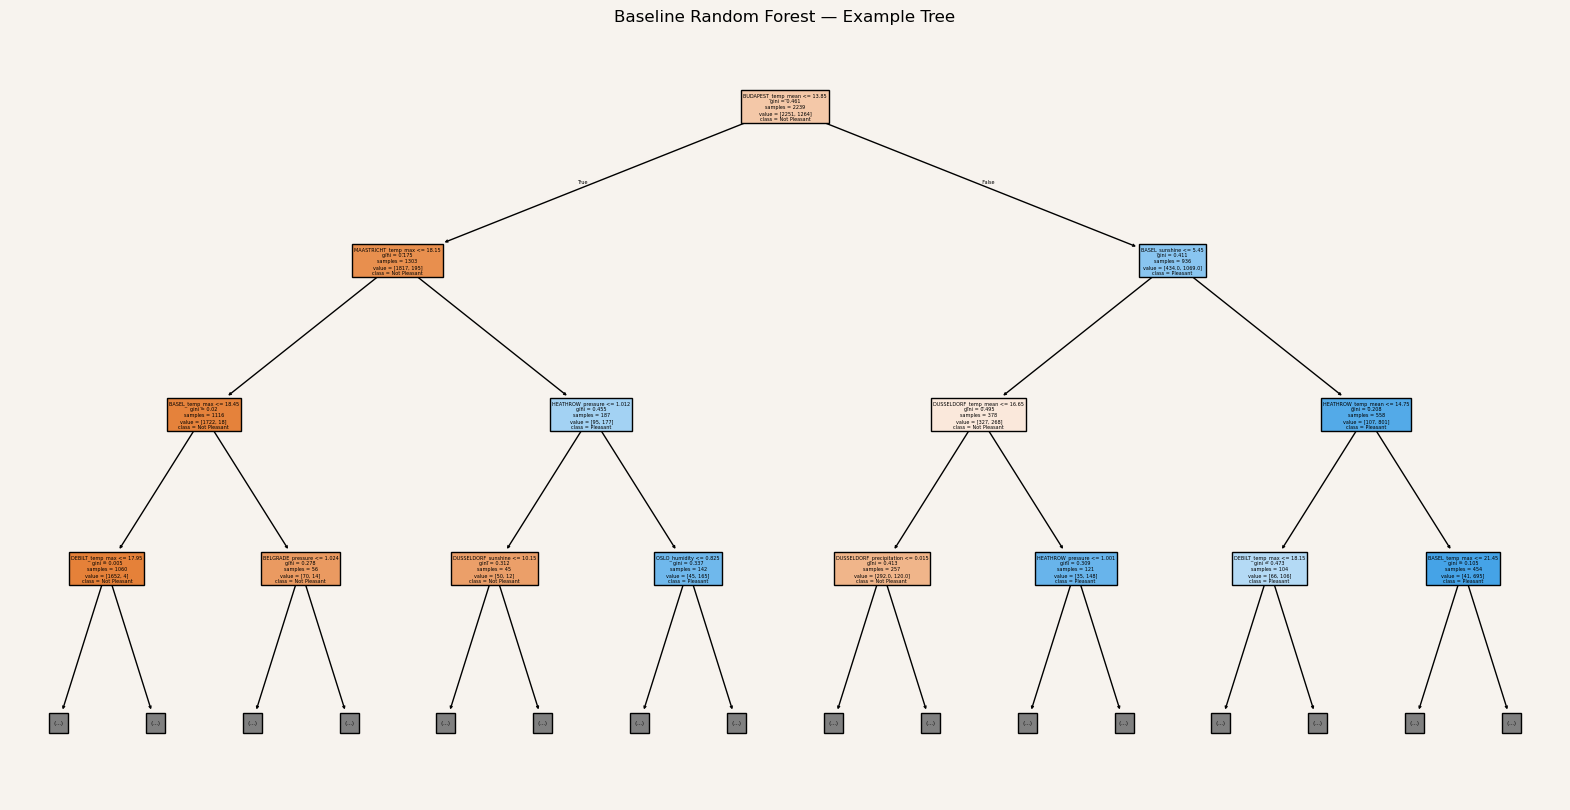

In [23]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10),  facecolor="#F7F3EE")
plot_tree(
    rf_baseline.estimators_[0],
    feature_names=X.columns,
    class_names=["Not Pleasant", "Pleasant"],
    filled=True,
    max_depth=3
)
plt.gca().set_facecolor("#F7F3EE") 
plt.title("Baseline Random Forest â€” Example Tree")
plt.show()


## Hyperparamether Search

In [26]:
param_dist = {
    "n_estimators": randint(50, 200),
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5),
    "max_features": ["sqrt", "log2"]
}


In [27]:
rf_random = RandomizedSearchCV(
    estimator=rf_baseline,      # baseline RF
    param_distributions=param_dist,
    n_iter=20,                  # start small
    cv=3,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1,
    verbose=2
)

rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=9, n_estimators=87; total time=   0.6s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=9, n_estimators=87; total time=   0.7s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=180; total time=   1.2s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=156; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=137; total time=   1.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=137; total time=   1.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=156; total time=   1.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=156; 

,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'max_depth': [None, 5, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': <scipy.stats....t 0x3395fbb10>, 'min_samples_split': <scipy.stats....t 0x3395fb610>, ...}"
,n_iter,20
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [28]:
rf_random.best_params_


{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 137}

In [29]:
rf_optimized = RandomForestClassifier(
    **rf_random.best_params_,
    random_state=42,
    n_jobs=-1
)

rf_optimized.fit(X_train, y_train)


,n_estimators,137
,criterion,'gini'
,max_depth,10
,min_samples_split,4
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
y_pred_opt = rf_optimized.predict(X_test)
optimized_accuracy = accuracy_score(y_test, y_pred_opt)

optimized_accuracy

0.9377133105802048

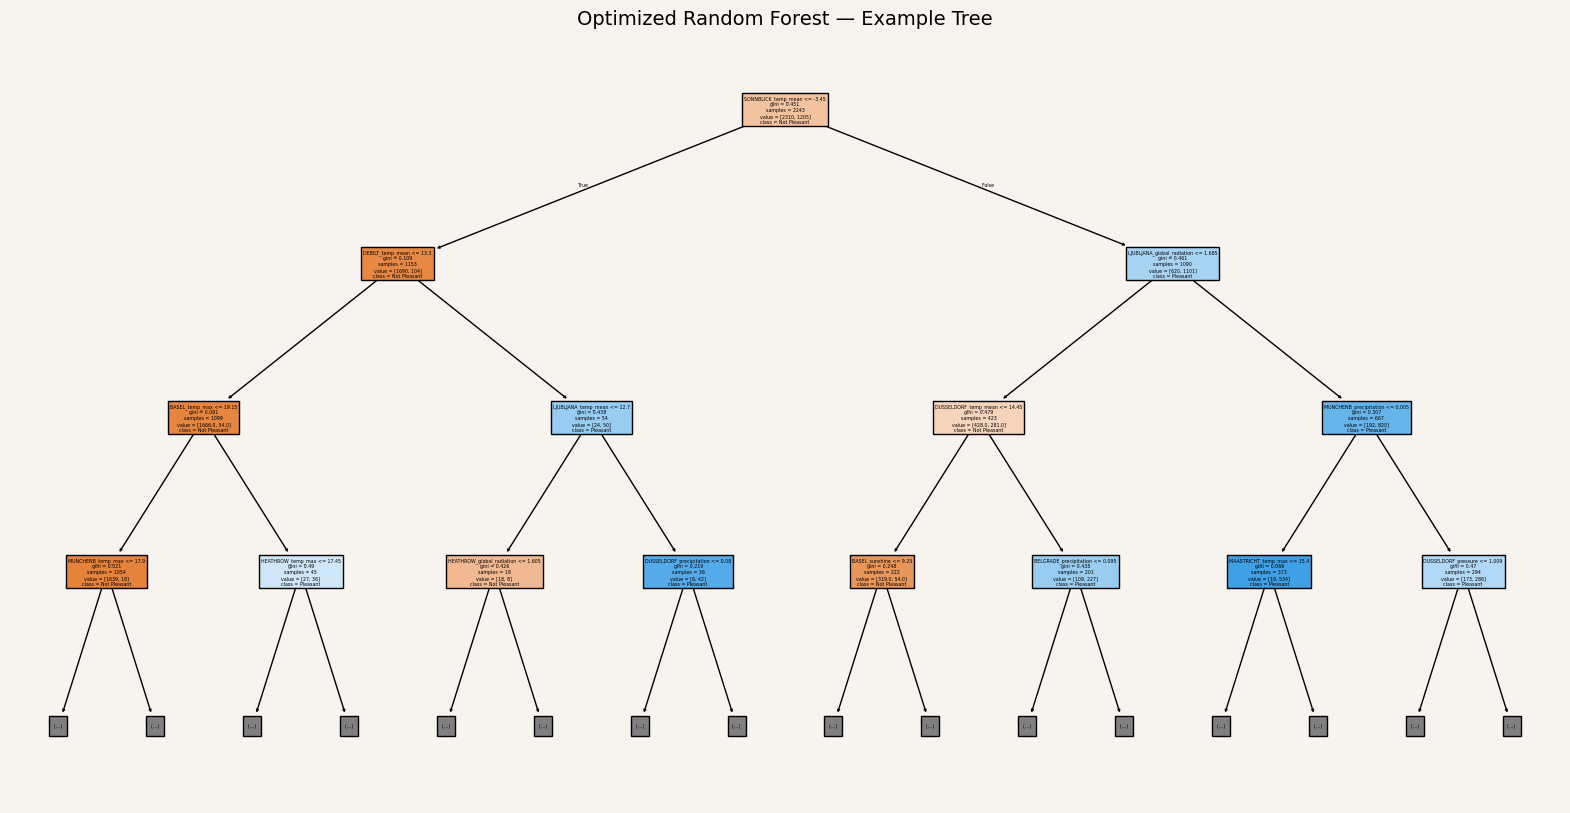

In [31]:
plt.figure(figsize=(20, 10), facecolor="#F7F3EE")

plot_tree(
    rf_optimized.estimators_[5],   # any valid tree index
    feature_names=X.columns,
    class_names=["Not Pleasant", "Pleasant"],
    filled=True,
    max_depth=3
)

plt.title("Optimized Random Forest â€” Example Tree", fontsize=14)
plt.show()


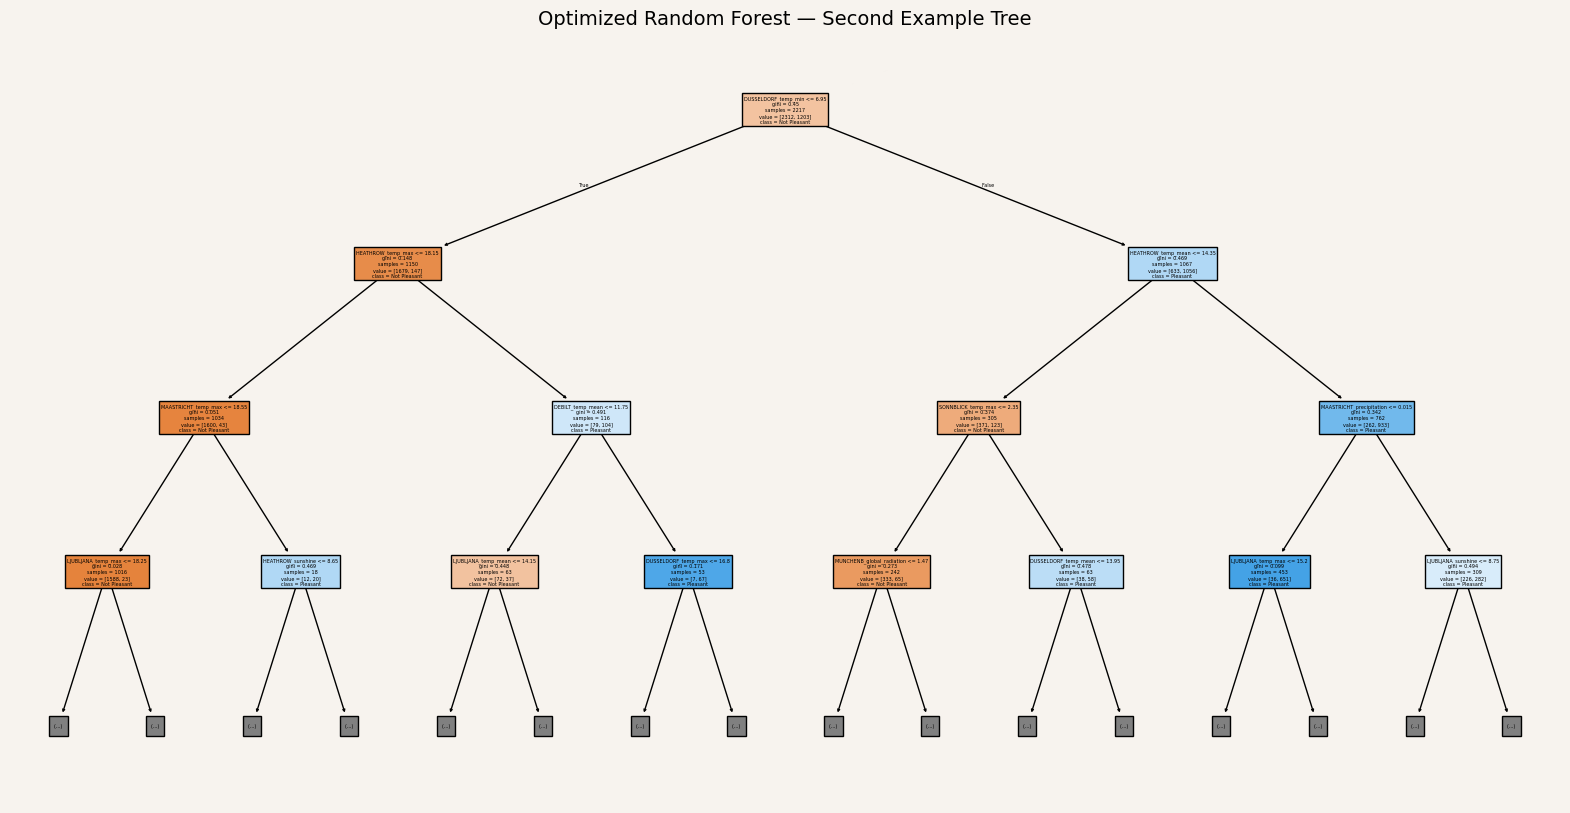

In [32]:
plt.figure(figsize=(20, 10), facecolor="#F7F3EE")

plot_tree(
    rf_optimized.estimators_[15],
    feature_names=X.columns,
    class_names=["Not Pleasant", "Pleasant"],
    filled=True,
    max_depth=3
)

plt.title("Optimized Random Forest â€” Second Example Tree", fontsize=14)
plt.show()


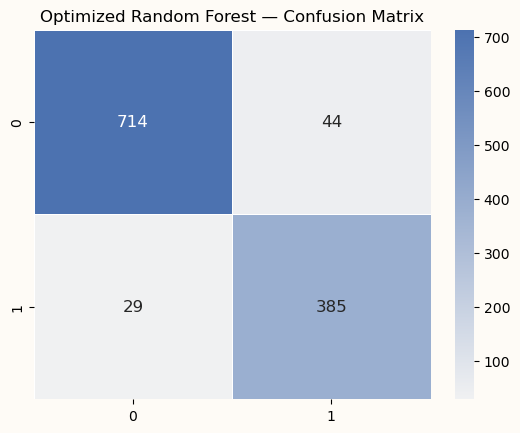

In [37]:
cm_opt = confusion_matrix(y_test, y_pred_opt)

sns.heatmap(
    cm_opt,
    annot=True,
    fmt="d",
    cmap=sns.light_palette("#4C72B0", as_cmap=True),
    cbar=True,
    linewidths=0.5,
    linecolor="white",
    annot_kws={"size": 12}
)

plt.gca().set_facecolor("#FEFBF6")
plt.gcf().patch.set_facecolor("#FEFBF6")
plt.title("Optimized Random Forest â€” Confusion Matrix")
plt.show()


In [38]:
# Optimized feature importance
opt_importances = rf_optimized.feature_importances_

opt_feature_importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": opt_importances
}).sort_values(by="importance", ascending=False)

opt_feature_importance_df.head(10)

,feature,importance
44,DUSSELDORF_temp_max,0.073746
8,BASEL_temp_max,0.071263
80,MAASTRICHT_temp_max,0.062600
78,MAASTRICHT_temp_mean,0.062495
35,DEBILT_temp_max,0.054239
98,MUNCHENB_temp_max,0.050336
51,HEATHROW_temp_mean,0.044910
6,BASEL_temp_mean,0.034941
96,MUNCHENB_temp_mean,0.034491
42,DUSSELDORF_temp_mean,0.027794


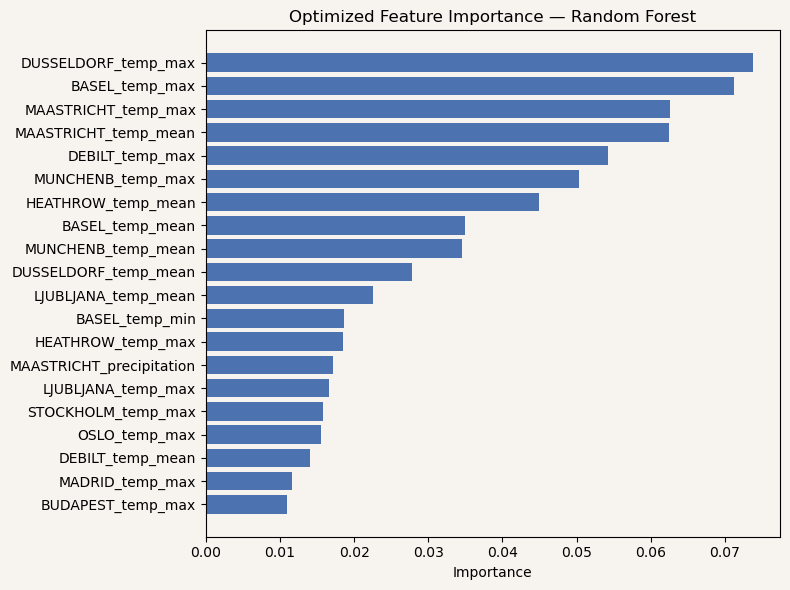

In [39]:
top_n = 20

plt.figure(figsize=(8, 6), facecolor="#F7F3EE")

plt.barh(
    opt_feature_importance_df.head(top_n)["feature"][::-1],
    opt_feature_importance_df.head(top_n)["importance"][::-1],
    color="#4C72B0"
)

plt.gca().set_facecolor("#F7F3EE")
plt.title("Optimized Feature Importance â€” Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [48]:
baseline_imp = feature_importance_df.set_index("feature")["importance"]
optimized_imp = opt_feature_importance_df.set_index("feature")["importance"]
feature_comparison = pd.concat(
    [baseline_imp, optimized_imp],
    axis=1,
    keys=["Baseline", "Optimized"]
).fillna(0)

feature_comparison.head(10)


,Baseline,Optimized
feature,,
DUSSELDORF_temp_max,0.069853,0.073746
MAASTRICHT_temp_mean,0.062889,0.062495
BASEL_temp_max,0.061242,0.071263
MUNCHENB_temp_max,0.060119,0.050336
MAASTRICHT_temp_max,0.054523,0.062600
HEATHROW_temp_mean,0.040284,0.044910
MUNCHENB_temp_mean,0.038416,0.034491
DEBILT_temp_max,0.031766,0.054239
DUSSELDORF_temp_mean,0.031268,0.027794


In [42]:
# Optimized Station importance
optimized_station_importance = (
    opt_feature_importance_df
    .assign(station=lambda df: df["feature"].str.split("_").str[0])
    .groupby("station")["importance"]
    .sum()
    .sort_values(ascending=False)
)

optimized_station_importance


station
MAASTRICHT    0.165440
BASEL         0.153263
DUSSELDORF    0.133790
MUNCHENB      0.118790
DEBILT        0.093503
HEATHROW      0.082415
LJUBLJANA     0.067900
OSLO          0.034692
STOCKHOLM     0.034053
SONNBLICK     0.029890
BELGRADE      0.026661
BUDAPEST      0.026079
MADRID        0.025294
KASSEL        0.007052
VALENTIA      0.001178
Name: importance, dtype: float64

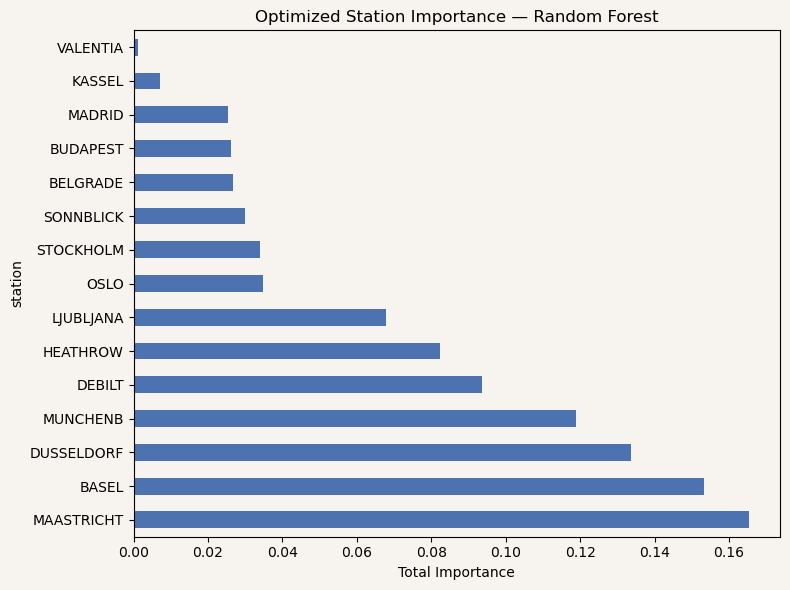

In [43]:
plt.figure(figsize=(8, 6), facecolor="#F7F3EE")

optimized_station_importance.plot(
    kind="barh",
    color="#4C72B0"
)

plt.gca().set_facecolor("#F7F3EE")
plt.title("Optimized Station Importance â€” Random Forest")
plt.xlabel("Total Importance")
plt.tight_layout()
plt.show()


In [44]:
station_comparison = pd.DataFrame({
    "Baseline": baseline_station_importance,
    "Optimized": optimized_station_importance
}).fillna(0)

station_comparison


,Baseline,Optimized
station,,
BASEL,0.141634,0.153263
BELGRADE,0.032640,0.026661
BUDAPEST,0.028120,0.026079
DEBILT,0.078967,0.093503
DUSSELDORF,0.138348,0.133790
HEATHROW,0.078924,0.082415
KASSEL,0.010874,0.007052
LJUBLJANA,0.073033,0.067900
MAASTRICHT,0.152701,0.165440
